In [1]:
import os
#import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import r2_score
from typing import Tuple

In [3]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [4]:
NTRY = 24
#NAME = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose'
#NAME_CB  = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose_cat'
#NAME_XGB = f'{NTRY}_xgb_pca64_sber_lags_parse_bord_nose_cat'
#NAME_LGB = f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose_cat'
#xgb_pca64_sber_lags_parse_bord_nose_val_part

In [5]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

# Конкатенация

In [6]:
#subm_views = pd.read_csv(os.path.join(DIR_SUBM, f'1_xgb_baseline_test.csv'),  usecols=['document_id', 'views'])
subm_views = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_bord_nose_iter_poly.csv'),  usecols=['document_id', 'views'])
subm_depth = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_bord_nose_iter_poly.csv'), usecols=['document_id', 'depth'])
subm_frp   = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_bord_nose_iter_poly.csv'), usecols=['document_id', 'full_reads_percent'])

#ubm_depth = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose_irq.csv'), usecols=['document_id', 'depth'])
#ubm_frp   = pd.read_csv(os.path.join(DIR_SUBM, f'14_lgb_pca64_sber_lags_parse_bord_nose.csv'),   usecols=['document_id', 'full_reads_percent'])

print(subm_views.shape, subm_depth.shape, subm_frp.shape)

(3000, 2) (3000, 2) (3000, 2)


In [7]:
subm = subm_views.merge(subm_depth, on='document_id', validate='one_to_one')
#subm = subm.merge(subm_depth, on='document_id', validate='one_to_one')
subm = subm.merge(subm_frp, on='document_id', validate='one_to_one')

In [8]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_concatenate.csv'), index = False)

# Ансамбли

In [48]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [8]:
train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), usecols = ['document_id', 'views', 'depth', 'full_reads_percent'])
val  = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), usecols = ['document_id', 'views', 'depth', 'full_reads_percent'])

cb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_CB}_train_part.csv'))
cb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_CB}_val_part.csv'))

xgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_XGB}_train_part.csv'))
xgb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_XGB}_val_part.csv'))

lgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_LGB}_train_part.csv'))
lgb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_LGB}_val_part.csv'))

In [9]:
print('before ', cb_train.shape, lgb_train.shape, xgb_train.shape)
print('before ', cb_val.shape, lgb_val.shape, xgb_val.shape)
train = pd.concat([train.reset_index(drop = True),
                   cb_train.reset_index(drop = True),
                   xgb_train.reset_index(drop = True),
                   lgb_train.reset_index(drop = True),
                  ], ignore_index = True, axis = 1)

val = pd.concat([val.reset_index(drop = True),
                 cb_val.reset_index(drop = True),
                 xgb_val.reset_index(drop = True),
                 lgb_val.reset_index(drop = True),
                ], ignore_index = True, axis = 1)

cols = ['document_id', 'views', 'depth', 'full_reads_percent',
         'document_id_cb', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb',
         'document_id_xgb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
         'document_id_lgb', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb',
        ]
train.columns = cols
val.columns = cols

if sum(train.document_id == train.document_id_xgb) != train.shape[0] or \
   sum(train.document_id == train.document_id_lgb) != train.shape[0]:
    print('wtf train')
    
if sum(val.document_id == val.document_id_xgb) != val.shape[0] or \
   sum(val.document_id == val.document_id_lgb) != val.shape[0]:
    print('wtf val')

train.drop(['document_id_cb', 'document_id_xgb', 'document_id_lgb'], axis = 1, inplace = True)
val.drop(['document_id_cb', 'document_id_xgb', 'document_id_lgb'], axis = 1, inplace = True)
    
    
print('after ', train.shape)
print('after ', val.shape)

before  (5584, 4) (5584, 4) (5584, 4)
before  (1397, 4) (1397, 4) (1397, 4)
after  (5584, 13)
after  (1397, 13)


In [11]:
val.columns[4:]

Index(['views_pred_cb', 'depth_pred_cb', 'frp_pred_cb', 'views_pred_xgb',
       'depth_pred_xgb', 'frp_pred_xgb', 'views_pred_lgb', 'depth_pred_lgb',
       'frp_pred_lgb'],
      dtype='object')

# нормализуем

In [56]:
scaler = preprocessing.StandardScaler()  #Standardize features by removing the mean and scaling to unit variance.

scaler.fit(train[train.columns[4:]])

train[train.columns[4:]] = scaler.transform(train[train.columns[4:]])
val[train.columns[4:]]  = scaler.transform(val[train.columns[4:]])

In [74]:
#!!!!!!!!! нормализовать предикты
#!!!!!!!!! сделать предикты

In [57]:
#def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    
    #preds = np.array(y_pred[0])
    #print(type(y_true))
    #print(type(y_pred)) # np.array
    
    return 'r2', r2_score(y_true.get_label(), y_pred)

# views

In [58]:
cv_ntrees = 100

xgb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['views']])
dval   = xgb.DMatrix(val[train.columns[4:]], label=val[['views']])

In [59]:
%%time
score = xgb.cv(xgb_params_views, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 6.67 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,2077.195388,1380.273386,24738.364685,11765.746847,0.998486,0.001187,0.835639,0.069107
96,2077.043059,1380.425077,24738.403552,11765.698982,0.998487,0.001188,0.835639,0.069107
97,2076.946484,1380.507568,24738.362038,11765.570842,0.998487,0.001188,0.835639,0.069105
98,2076.855171,1380.585848,24738.347709,11765.576983,0.998487,0.001188,0.835639,0.069106
99,2076.743271,1380.698771,24738.387090,11765.560832,0.998487,0.001188,0.835638,0.069106


In [60]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
96,2077.043059,1380.425077,24738.403552,11765.698982,0.998487,0.001188,0.835639,0.069107


In [61]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
42,2233.157014,1245.821638,24735.849811,11774.430066,0.998404,0.001183,0.835706,0.069172


# сейчас учу только на тесте

In [62]:
xgb_model_views = XGBRegressor(n_estimators=45, 
                               max_depth=15, 
                               eta=0.3, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_views.fit(train[train.columns[4:]], train[['views']],
                    early_stopping_rounds=5,
                    eval_set=[(val[val.columns[4:]], val[['views']])], 
                    verbose=False
                   )

# Get predictions and metrics
preds_train_views = xgb_model_views.predict(train[train.columns[4:]])
preds_val_views   = xgb_model_views.predict(val[train.columns[4:]])

train_score_views = r2_score(train["views"], preds_train_views)
val_score_views   = r2_score(val["views"],   preds_val_views)

train_score_views, val_score_views

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


(0.8343937228394471, 0.31107061472247877)

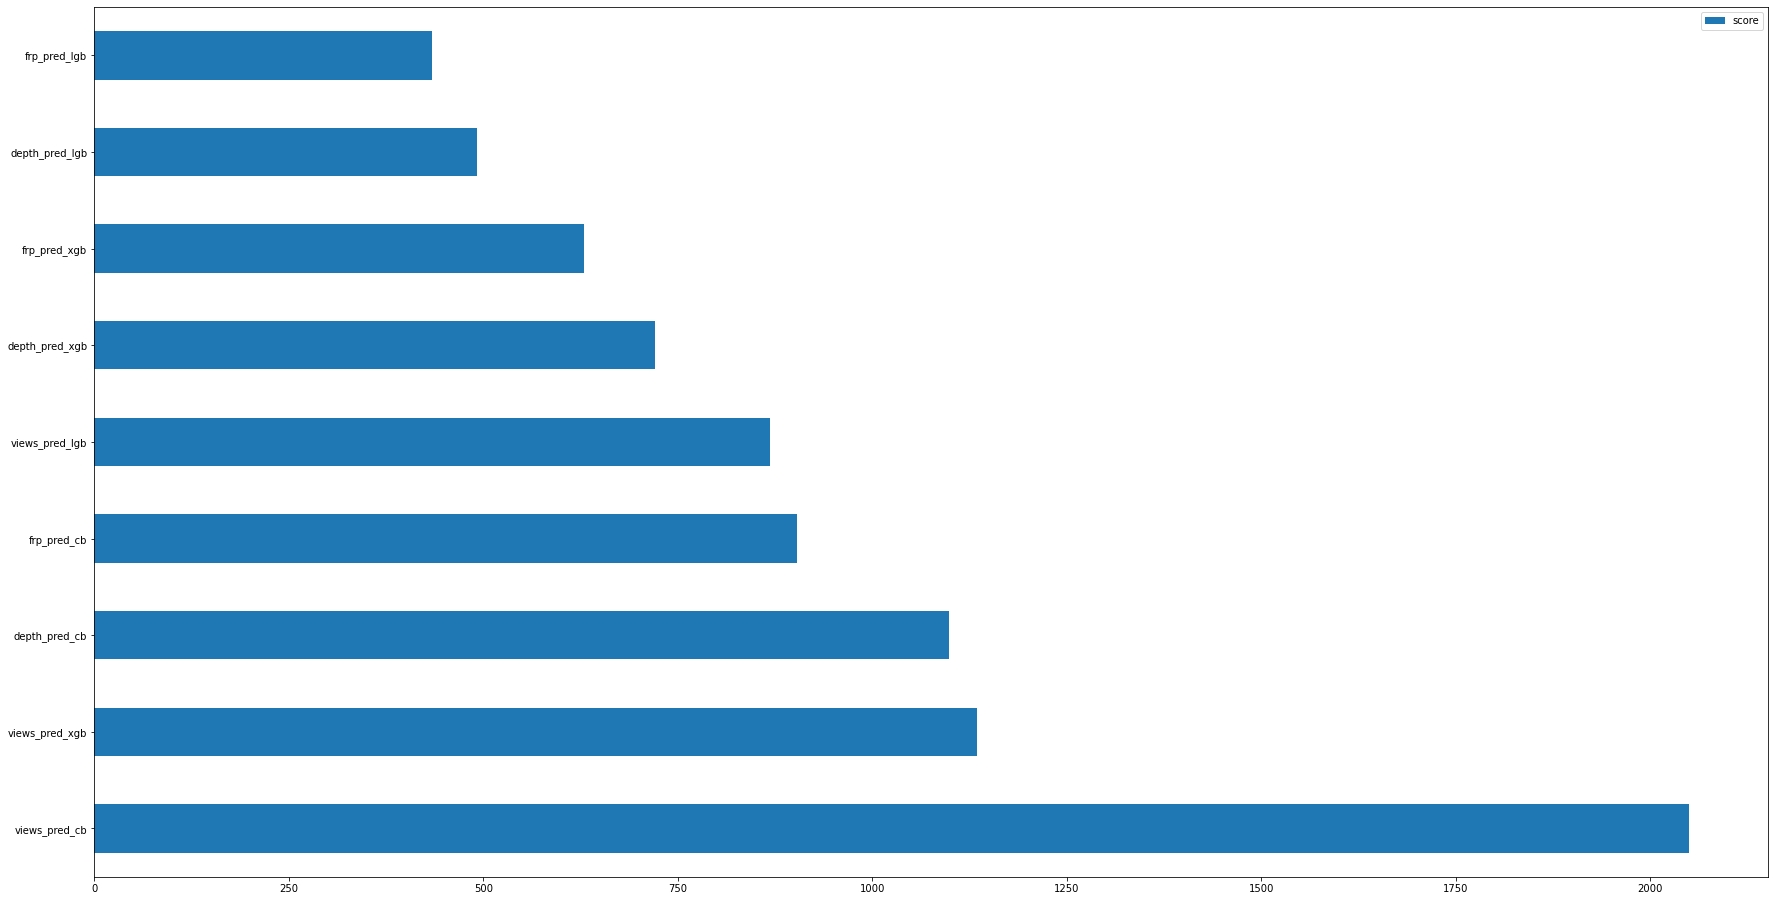

In [63]:
plot_importance(xgb_model_views, 30, 'weight')

# depth

In [64]:
#cv_ntrees = 100

xgb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['depth']])

In [65]:
%%time
score = xgb.cv(xgb_params_depth, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 3.55 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,0.001162,0.000065,0.01268,0.00045,0.999652,0.000037,0.95834,0.00438
96,0.001162,0.000065,0.01268,0.00045,0.999652,0.000037,0.95834,0.00438
97,0.001162,0.000065,0.01268,0.00045,0.999652,0.000037,0.95834,0.00438
98,0.001162,0.000065,0.01268,0.00045,0.999652,0.000037,0.95834,0.00438
99,0.001162,0.000065,0.01268,0.00045,0.999652,0.000037,0.95834,0.00438


In [66]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
43,0.001162,0.000065,0.012681,0.00045,0.999652,0.000037,0.958339,0.00438


In [67]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
24,0.002295,0.000154,0.012651,0.00045,0.998639,0.000184,0.958535,0.00437


In [68]:
xgb_model_depth = XGBRegressor(n_estimators=45, 
                               max_depth=15, 
                               eta=0.3, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_depth.fit(train[train.columns[4:]], train[['depth']],
                    early_stopping_rounds=5,
                    eval_set=[(val[val.columns[4:]], val[['depth']])], 
                    verbose=False
                   )

# Get predictions and metrics
preds_train_depth = xgb_model_depth.predict(train[train.columns[4:]])
preds_val_depth   = xgb_model_depth.predict(val[train.columns[4:]])

train_score_depth = r2_score(train["depth"], preds_train_depth)
val_score_depth   = r2_score(val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


(0.9919740199746253, 0.771698906687095)

# full_reads_percent

In [69]:
#cv_ntrees = 100

xgb_params_frp = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    'eta': 0.3,
    'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(train[train.columns[4:]], label=train[['full_reads_percent']])

In [70]:
%%time
score = xgb.cv(xgb_params_frp, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 6.48 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,0.075258,0.017332,3.345804,0.076834,0.999942,0.000025,0.890576,0.006483
96,0.075098,0.017347,3.345816,0.076859,0.999942,0.000025,0.890575,0.006484
97,0.074946,0.017306,3.345889,0.076879,0.999942,0.000025,0.890570,0.006485
98,0.074835,0.017332,3.345892,0.076847,0.999942,0.000025,0.890570,0.006483
99,0.074718,0.017345,3.345885,0.076851,0.999943,0.000024,0.890570,0.006483


In [71]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
99,0.074718,0.017345,3.345885,0.076851,0.999943,0.000024,0.89057,0.006483


In [72]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
15,0.794656,0.037354,3.331409,0.080676,0.993823,0.000619,0.891516,0.006504


In [73]:
xgb_model_frp = XGBRegressor(n_estimators=45, 
                               max_depth=15, 
                               eta=0.3, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_frp.fit(train[train.columns[4:]], train[['full_reads_percent']],
                    early_stopping_rounds=5,
                    eval_set=[(val[val.columns[4:]], val[['full_reads_percent']])], 
                    verbose=False
                   )

# Get predictions and metrics
preds_train_frp = xgb_model_frp.predict(train[train.columns[4:]])
preds_val_frp   = xgb_model_frp.predict(val[train.columns[4:]])

train_score_frp = r2_score(train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


(0.9858559958099626, 0.42855295708911034)

In [10]:
def plot_corrc(inp_df, inp_cols, targ_cols = ['views', 'depth', 'full_reads_percent']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(), 
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'), 
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])
    
    sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,) #hue = 'c2')

In [11]:
#plot_corrc(train, ['views'], ['views_pred_cb'])
#plot_corrc(train, ['views'], ['views_pred_xgb'])
#plot_corrc(train, ['views'], ['views_pred_lgb'])

In [75]:
#plot_corrc(train, ['depth'], ['depth_pred_cb'])
plot_corrc(train, ['depth'], ['depth_pred_xgb'])
#plot_corrc(train, ['depth'], ['depth_pred_lgb'])

NameError: name 'plot_corrc' is not defined